In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from hindemith import hmarray
from hindemith.core import compose
from hindemith.operations.array import Square
from hindemith.operations.convolve import Convolve2D
import hindemith as hm
import cv2
from hmcaffe.demo.classify import classify
from box import get_boxes
import numpy as np

def show_bgr_im(frame):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

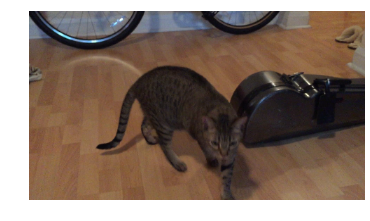

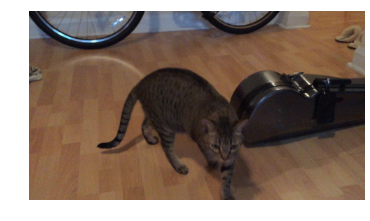

In [9]:
frame0 = cv2.resize(cv2.imread('images/output-0099.png'), (480, 270))
frame1 = cv2.resize(cv2.imread('images/output-0100.png'), (480, 270))

show_bgr_im(frame0)
show_bgr_im(frame1)

In [10]:
alpha = 15

jacobi = np.array([
    [1.0/12.0, 1.0/6.0, 1.0/12.0],
    [1.0/6.0, 0.0, 1.0/6.0],
    [1.0/12.0, 1.0/6.0, 1.0/12.0]
])

dx = np.array([[-1.0/12.0, -2.0/3.0, 0.0, 2.0/3.0, 1.0/12.0]])
dy = np.array([[-1.0/12.0], [-2.0/3.0], [0.0], [2.0/3.0], [1.0/12.0]])

alpha2 = alpha ** 2
epsilon = .01

@compose
def hs_jacobi(im0, im1, u, v):
    It = im1 - im0
    Iy = Convolve2D(im1, dy)
    Ix = Convolve2D(im1, dx)
    denom = Square(Ix) + Square(Iy) + alpha2

    for _ in range(100):
        ubar = Convolve2D(u, jacobi)
        vbar = Convolve2D(v, jacobi)
        t = (Ix * ubar + Iy * vbar + It) / denom
        u_new = ubar - Ix * t
        v_new = vbar - Iy * t
        u, v = u_new, v_new
    return u, v


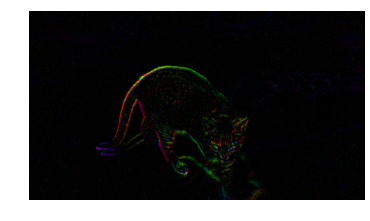

In [14]:
hsv = np.zeros_like(frame0)
im0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY).astype(np.float32).view(hmarray)
hm_u = hm.zeros_like(im0)
hm_v = hm.zeros_like(im0)
im1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY).astype(np.float32).view(hmarray)

hm_u, hm_v = hs_jacobi(im0, im1, hm_u, hm_v)

hm_u.sync_host()
hm_v.sync_host()
mag, ang = cv2.cartToPolar(hm_u, hm_v)
mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
ang = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 0] = ang
hsv[..., 2] = mag
flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
show_bgr_im(flow)

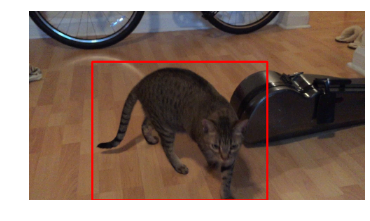

In [12]:
windowed = np.copy(frame1)
windows = get_boxes(mag, windowed)
show_bgr_im(windowed)

---------
['n02124075', 'Egyptian', 'cat']
['n02123045', 'tabby,', 'tabby', 'cat']
['n02123159', 'tiger', 'cat']
['n01873310', 'platypus,', 'duckbill,', 'duckbilled', 'platypus,', 'duck-billed', 'platypus,', 'Ornithorhynchus', 'anatinus']
['n01704323', 'triceratops']


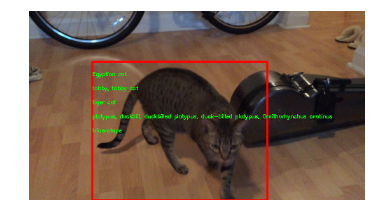

In [13]:
labeled = np.copy(windowed)
for window in windows:
    labels = classify(frame1[window[0]:window[2],
                             window[1]:window[3]])
    print("---------")
    for i, label in enumerate(reversed(labels)):
        label = label.split(" ")
        cv2.putText(labeled, " ".join(label[1:]), (window[1], window[0] + (i + 1) * 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, .25, (0, 255, 0), 1)
        print(label)

show_bgr_im(labeled)